In [20]:
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import pywt
import ptwt

from functools import partial

import large_scale_UQ as luq
import optimusprimal as optpr

import scipy.misc
from scipy.signal import resample
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from mpl_toolkits.axes_grid1 import make_axes_locatable


True
1
0
NVIDIA A100-PCIE-40GB


In [30]:
options = {"tol": 1e-8, "iter": 2500, "update_iter": 50, "record_iters": False}


In [47]:
ISNR = 25.0                                            # Input signal to noise ratio
sigma = 10 ** (-ISNR / 20.0)                           # Noise standard deviation
print('sigma: ', sigma)
reg_param = 2.5                                        # Regularisation parameter
res = 256                                              # Resolution we want to work with

x = scipy.misc.ascent()                                      # Scipy's ascent benchmark image
for i in range(2):
    x = resample(x, axis=i, num=res)
x /= np.nanmax(x)                                      # Normalise image

n = np.random.normal(0, sigma, x.shape)                # Random Gaussian noise
y = x + n     

y_torch = torch.tensor(y, device='cuda').reshape((1,) + y.shape)
y_torch.shape


sigma:  0.05623413251903491


torch.Size([1, 256, 256])

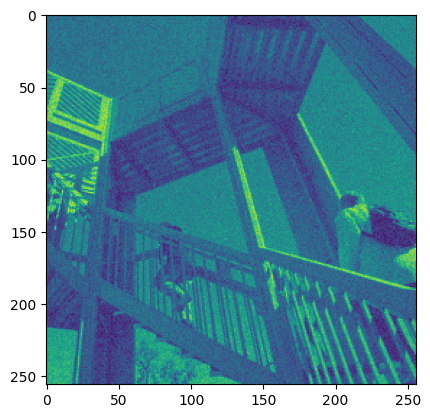

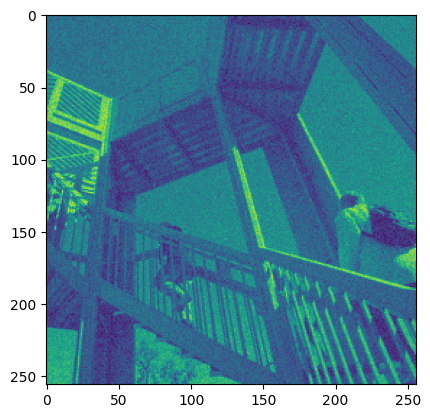

In [48]:

plt.figure()
plt.imshow(y_torch.detach().cpu().squeeze().numpy())

plt.figure()
plt.imshow(y)

In [49]:
reg_param_FB = 1.2e-2

# Define the grad
g = luq.operators.L2Norm_torch(sigma, torch.clone(y_torch), luq.empty.Identity())
g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wavs_list = ["db1", "db4"]  # ['db8'] # ["db1", "db4"] 
levels = 4
psi = luq.operators.DictionaryWv_torch(wavs_list, levels)

# Define the l1 norm with dict psi
# gamma = torch.max(torch.abs(psi.dir_op(y_torch))) * reg_param
np_psi = optpr.linear_operators.dictionary(wavs_list, levels, y.shape)

h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
gamma = h._get_max_abs_coeffs(h.dir_op(y_torch)) * reg_param_FB
h.gamma = gamma
h.beta = 1.0


alpha = 2. / (g.beta + 2.)
tau = 1

print('alpha: ', alpha)
print('gamma: ', gamma)
print('sigma: ', sigma)

gamma:  0.1372919974731695
alpha:  0.006284806712605263
gamma:  0.1372919974731695
sigma:  0.05623413251903491


In [50]:
wvlt_best_estimate, wvlt_diagnostics = luq.optim.FB_torch(
        x_init=y_torch,
        options=options,
        g=g,
        f=None,
        h=h,
        alpha=alpha,
        tau=1.,
        viewer=None,
)

x_hat = luq.utils.to_numpy(wvlt_best_estimate)


Running Base Forward Backward
[Forward Backward] 0 out of 2500 iterations, tol = 1.89e-01
[Forward Backward] 0 out of 2500 iterations, tol = 1.89e-01
[Forward Backward] 1 out of 2500 iterations, tol = 1.48e-01
[Forward Backward] 2 out of 2500 iterations, tol = 1.29e-01
[Forward Backward] 3 out of 2500 iterations, tol = 1.26e-01
[Forward Backward] 4 out of 2500 iterations, tol = 1.13e-01
[Forward Backward] 5 out of 2500 iterations, tol = 1.13e-01
[Forward Backward] 6 out of 2500 iterations, tol = 1.03e-01
[Forward Backward] 7 out of 2500 iterations, tol = 1.04e-01
[Forward Backward] 8 out of 2500 iterations, tol = 9.61e-02
[Forward Backward] 9 out of 2500 iterations, tol = 9.72e-02
[Forward Backward] 10 out of 2500 iterations, tol = 9.03e-02
[Forward Backward] 11 out of 2500 iterations, tol = 9.16e-02
[Forward Backward] 12 out of 2500 iterations, tol = 8.55e-02
[Forward Backward] 13 out of 2500 iterations, tol = 8.68e-02
[Forward Backward] 14 out of 2500 iterations, tol = 8.13e-02
[Forw

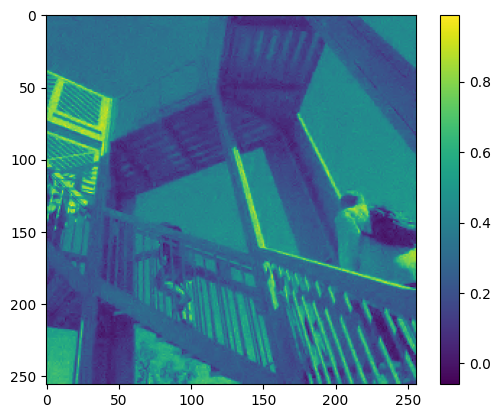

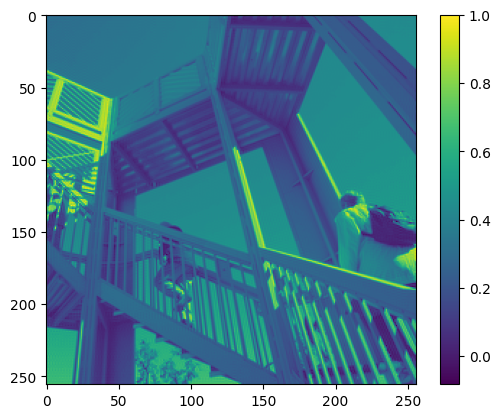

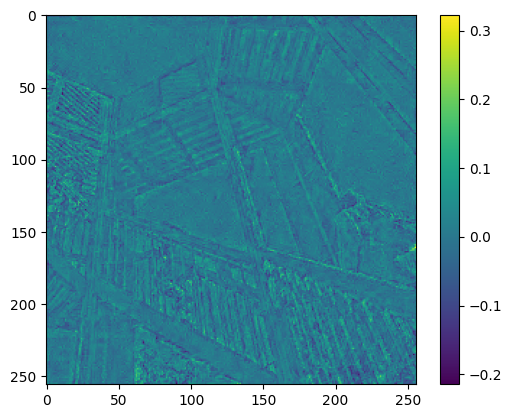

In [51]:
plt.figure()
plt.imshow(x_hat)
plt.colorbar()


plt.figure()
plt.imshow(x)
plt.colorbar()

plt.figure()
plt.imshow(x-x_hat)
plt.colorbar()

In [52]:
reg_param_FB = 1.2e-2

# Define the grad
optpr_g = optpr.grad_operators.l2_norm(sigma, np.copy(y), optpr.linear_operators.identity())
optpr_g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wav = ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 4                                               # Wavelet levels to consider [1-6]
optpr_psi = optpr.linear_operators.dictionary(wav, levels, x.shape)  # Wavelet linear operator


optpr_h = optpr.prox_operators.l1_norm(np.max(np.abs(optpr_psi.dir_op(y))) * reg_param_FB, optpr_psi)
optpr_h.beta = 1.0


tau = 1.

alpha = 2 / (optpr_g.beta + 2)
print('alpha: ', alpha)
gamma = np.max(np.abs(optpr_psi.dir_op(y))) * reg_param_FB
print('gamma: ', gamma)
print('sigma: ', sigma)

alpha:  0.006284806712605263
gamma:  0.09708010241592455
sigma:  0.05623413251903491


In [53]:

# Run the alg

np_FB_best_estimate, np_FB_diagnostics = optpr.forward_backward.FB(
    x_init=y,
    options=options,
    g=optpr_g,
    f=None,
    h=optpr_h,
    alpha=alpha,
    tau=1
)

np_FB_best_estimate = np.real(np_FB_best_estimate)


2023-03-17 16:31:25,214 - Optimus Primal - INFO - Running Base Forward Backward
2023-03-17 16:31:25,229 - Optimus Primal - INFO - [Forward Backward] 0 out of 2500 iterations, tol = 0.189493
2023-03-17 16:31:25,852 - Optimus Primal - INFO - [Forward Backward] 50 out of 2500 iterations, tol = 0.043025
2023-03-17 16:31:26,470 - Optimus Primal - INFO - [Forward Backward] 100 out of 2500 iterations, tol = 0.024793
2023-03-17 16:31:27,087 - Optimus Primal - INFO - [Forward Backward] 150 out of 2500 iterations, tol = 0.020282
2023-03-17 16:31:27,704 - Optimus Primal - INFO - [Forward Backward] 200 out of 2500 iterations, tol = 0.020625
2023-03-17 16:31:28,321 - Optimus Primal - INFO - [Forward Backward] 250 out of 2500 iterations, tol = 0.021616
2023-03-17 16:31:28,938 - Optimus Primal - INFO - [Forward Backward] 300 out of 2500 iterations, tol = 0.022435
2023-03-17 16:31:29,555 - Optimus Primal - INFO - [Forward Backward] 350 out of 2500 iterations, tol = 0.023028
2023-03-17 16:31:30,175 - O

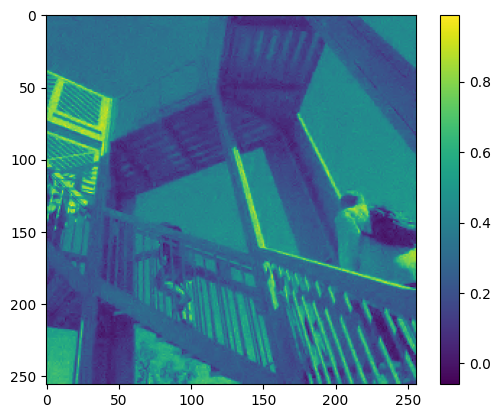

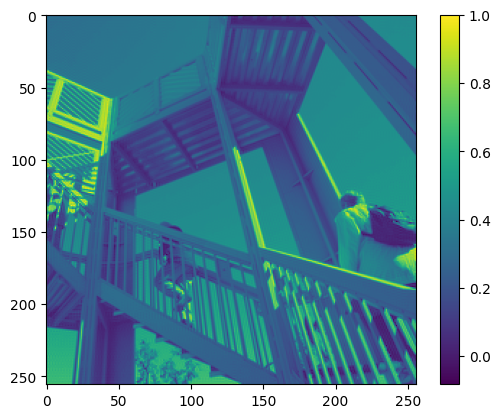

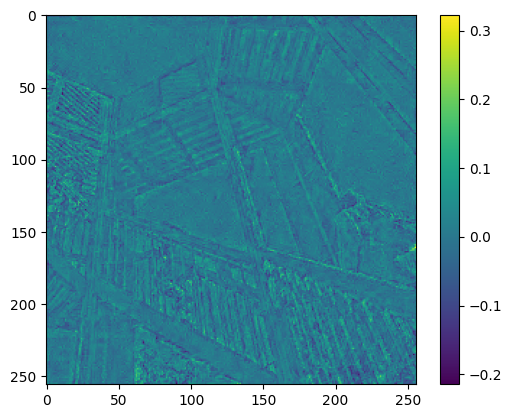

: 

In [54]:
plt.figure()
plt.imshow(np_FB_best_estimate)
plt.colorbar()


plt.figure()
plt.imshow(x)
plt.colorbar()

plt.figure()
plt.imshow(x-np_FB_best_estimate)
plt.colorbar()
